In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install neuralprophet[live]
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date, datetime
import seaborn as sns
import pickle
from neuralprophet import NeuralProphet, set_random_seed


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Load Data

In [3]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
FORECAST_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Forecast"

In [4]:
NYC = pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv", index_col = 0)
NYC = NYC.rename({'Time Stamp': 'ds', 'N.Y.C.': 'y'}, axis = 1)
NYC['ds'] = pd.to_datetime(NYC.ds)
NYC = NYC.drop(labels = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'LONGIL', 'MHK VL', 
                   'HUD VL', 'MILLWD', 'NORTH', 'WEST', 'NYCA', 
                   'month', 'day', 'hour', 'minute', 'PeriodEnd', 'PeriodStart',
                   'Period', 'datetime','dow_x','dow_y'], axis = 1)



In [5]:
NYC

,ds,y,year,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,...,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,HourlyDryBulbTemperature,HourlyRelativeHumidity
0,2017-01-01 00:00:00,5116.9000,2017,6.8,1.0,76.4,-4.8,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,226.0,7.0,162.0,0.12,44.000000,51.0
1,2017-01-01 00:05:00,5102.1000,2017,6.8,-3.0,76.4,-4.8,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,227.0,7.0,162.0,0.13,44.000000,51.0
2,2017-01-01 00:10:00,5074.9000,2017,6.8,-7.0,76.4,-4.7,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,227.0,7.0,162.0,0.13,44.000000,51.0
3,2017-01-01 00:15:00,5089.6000,2017,6.8,-11.0,76.4,-4.7,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,228.0,7.0,162.0,0.13,44.000000,51.0
4,2017-01-01 00:20:00,5061.3000,2017,6.9,-14.0,76.4,-4.7,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,228.0,7.0,162.0,0.13,44.000000,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631003,2022-12-31 23:35:00,4749.6870,2022,8.6,19.0,89.7,8.5,0.0,0.0,0.0,...,27.5,99.2,0.0,1014.8,252.0,2.5,162.0,0.10,48.451613,100.0
631004,2022-12-31 23:40:00,4738.3370,2022,8.6,16.0,88.2,8.5,0.0,0.0,0.0,...,27.2,99.2,0.0,1014.7,251.0,2.4,162.0,0.10,48.290323,100.0
631005,2022-12-31 23:45:00,4731.2676,2022,8.5,12.0,86.5,8.4,0.0,0.0,0.0,...,26.9,99.2,0.0,1014.6,250.0,2.4,162.0,0.10,48.129032,100.0
631006,2022-12-31 23:50:00,4721.4570,2022,8.5,8.0,85.0,8.4,0.0,0.0,0.0,...,26.6,99.2,0.0,1014.5,249.0,2.3,162.0,0.10,48.500000,100.0


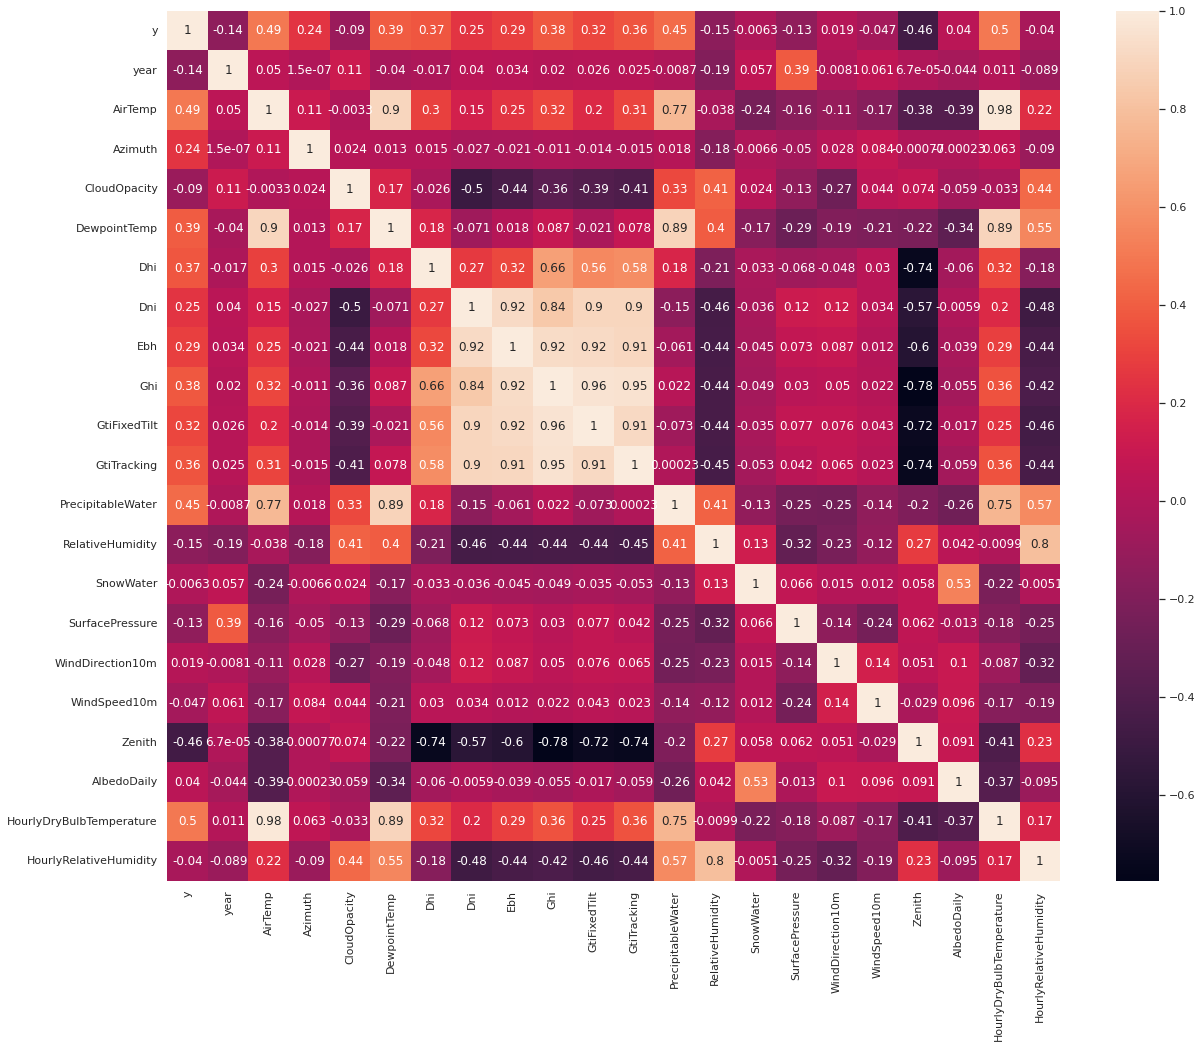

In [6]:
cormat = NYC.corr()
sns.set(rc={'figure.figsize':(20, 16)})
sns.heatmap(cormat,  annot=True);
# the few solar irridance measure are highly correlated, so just gonna pick one. 

In [7]:
train =  NYC[NYC.ds < '2022-1-1']
val = NYC.loc[len(train)-35:, ] #include last 18 point from 2021 so can make prediction for early 2022
val

,ds,y,year,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,...,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,HourlyDryBulbTemperature,HourlyRelativeHumidity
525853,2021-12-31 21:05:00,5152.0070,2021,9.5,78.0,69.3,7.3,0.0,0.0,0.0,...,19.2,86.2,0.0,1021.3,191.0,2.2,139.0,0.11,48.280000,99.16
525854,2021-12-31 21:10:00,5153.6836,2021,9.5,77.0,64.0,7.3,0.0,0.0,0.0,...,19.2,86.4,0.0,1021.3,191.0,2.2,140.0,0.11,48.380000,98.86
525855,2021-12-31 21:15:00,5144.9805,2021,9.4,76.0,60.3,7.3,0.0,0.0,0.0,...,19.2,86.5,0.0,1021.3,190.0,2.2,141.0,0.11,48.480000,98.56
525856,2021-12-31 21:20:00,5130.7990,2021,9.4,75.0,66.9,7.3,0.0,0.0,0.0,...,19.3,86.7,0.0,1021.3,190.0,2.3,142.0,0.11,48.580000,98.26
525857,2021-12-31 21:25:00,5095.8360,2021,9.4,74.0,74.1,7.3,0.0,0.0,0.0,...,19.3,86.8,0.0,1021.3,190.0,2.3,143.0,0.11,48.680000,97.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631003,2022-12-31 23:35:00,4749.6870,2022,8.6,19.0,89.7,8.5,0.0,0.0,0.0,...,27.5,99.2,0.0,1014.8,252.0,2.5,162.0,0.10,48.451613,100.00
631004,2022-12-31 23:40:00,4738.3370,2022,8.6,16.0,88.2,8.5,0.0,0.0,0.0,...,27.2,99.2,0.0,1014.7,251.0,2.4,162.0,0.10,48.290323,100.00
631005,2022-12-31 23:45:00,4731.2676,2022,8.5,12.0,86.5,8.4,0.0,0.0,0.0,...,26.9,99.2,0.0,1014.6,250.0,2.4,162.0,0.10,48.129032,100.00
631006,2022-12-31 23:50:00,4721.4570,2022,8.5,8.0,85.0,8.4,0.0,0.0,0.0,...,26.6,99.2,0.0,1014.5,249.0,2.3,162.0,0.10,48.500000,100.00


In [8]:
print(train.shape) # quick check to see if the size of data is expected. 
print(val.shape)

(525888, 23)
(105155, 23)


In [9]:
def get_cols(cols = None, train = train, val= val):
  col_requested = ['ds', 'y']
  if cols: 
    col_requested += cols
  return train[col_requested] , val[col_requested]



# Base Model with no additional feature 

In [10]:
m_base = NeuralProphet(n_lags=18,
                       n_forecasts = 18,
                       yearly_seasonality=True, #should set to True for full data set 
                       weekly_seasonality=True, 
                       daily_seasonality=True,
                       num_hidden_layers = 1,
                       epochs = 5)



In [11]:
train_base, val_base = get_cols()
set_random_seed(2023) #Note that you have to explicitly set the random seed to the same random number each time before fitting the model.
m_base_train_metric = m_base.fit(train_base, 
                                 validation_df = val_base,
                                 freq='5min')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO:NP.config:Auto-set batch_size to 128
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

  warnings.warn("Can't initialize NVML")

WARNING

Finding best initial lr:   0%|          | 0/293 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [12]:
m_base_train_metric

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,144.591644,169.162186,0.000726,0.0,0,1115.082886,1417.219360,0.091947,0.0
1,220.618759,254.048996,0.001657,0.0,1,102.688423,132.045746,0.000319,0.0
2,71.335182,92.197807,0.000204,0.0,2,91.287270,118.108170,0.000252,0.0
3,69.497299,86.620796,0.000177,0.0,3,68.610809,92.165497,0.000147,0.0
4,49.929253,69.801033,0.000117,0.0,4,55.170979,78.075874,0.000104,0.0


In [13]:
forecast = m_base.predict(val_base[['ds', 'y']], decompose = False)
m_base = m_base.highlight_nth_step_ahead_of_each_forecast(18)
forecast = forecast[35:]

# fig = m_base.plot(forecast.loc[n-t:,])


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [17]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,yhat9,yhat10,yhat11,yhat12,yhat13,yhat14,yhat15,yhat16,yhat17,yhat18
35,2022-01-01 00:00:00,4670.6790,4588.688965,4597.029785,4584.953613,4593.354980,4588.866211,4593.399414,4572.325684,4591.214844,4594.644531,4615.996094,4646.427734,4623.288086,4612.953613,4592.017578,4613.707031,4609.157227,4588.456055,4603.411621
36,2022-01-01 00:05:00,4623.9080,4580.836426,4587.947266,4588.229980,4582.037598,4581.941406,4579.651367,4588.589844,4562.708008,4585.373047,4589.835449,4607.006836,4637.608398,4616.331055,4599.104980,4568.372070,4612.051270,4605.497070,4581.105469
37,2022-01-01 00:10:00,4642.4116,4563.075195,4583.402344,4583.300293,4582.902832,4584.006348,4587.635742,4574.925293,4584.974121,4556.203125,4580.055664,4588.621582,4607.420410,4645.447754,4619.739258,4609.553223,4573.380859,4608.076660,4603.250977
38,2022-01-01 00:15:00,4606.2410,4554.761719,4554.293457,4578.741211,4577.098633,4575.368164,4577.812988,4582.387695,4572.187500,4580.061035,4548.824707,4574.673828,4581.253418,4600.084961,4628.566406,4611.586426,4602.586426,4555.921875,4606.921387
39,2022-01-01 00:20:00,4589.0850,4536.778320,4550.438477,4543.731445,4570.912109,4572.844727,4574.203125,4578.824707,4571.030762,4565.980957,4577.610352,4539.498535,4570.636719,4581.198242,4606.121582,4645.584961,4613.440430,4610.474121,4554.456055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105150,2022-12-31 23:35:00,4749.6870,4651.539062,4655.512695,4660.952148,4640.813477,4643.795898,4664.521484,4686.568848,4687.443359,4672.936035,4648.376465,4650.318359,4620.383789,4649.240234,4642.255371,4604.535156,4632.369629,4659.380859,4731.885742
105151,2022-12-31 23:40:00,4738.3370,4626.185547,4639.554688,4646.325195,4650.613281,4632.084473,4640.797852,4660.431641,4680.095703,4679.599121,4667.612305,4645.120605,4645.243164,4605.383301,4649.802734,4637.254883,4589.519043,4636.188477,4654.533203
105152,2022-12-31 23:45:00,4731.2676,4616.769531,4610.974121,4630.270508,4639.211914,4646.591797,4626.932617,4636.686523,4655.322754,4677.965332,4677.887207,4665.044434,4637.651855,4638.458984,4610.047363,4635.939453,4627.094238,4582.546875,4625.339844
105153,2022-12-31 23:50:00,4721.4570,4618.297852,4607.869629,4600.763672,4622.866211,4631.599609,4631.639648,4620.585449,4631.737305,4654.870605,4674.970215,4683.684082,4658.889160,4636.081055,4636.149414,4591.003906,4634.587891,4622.110352,4571.426758


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


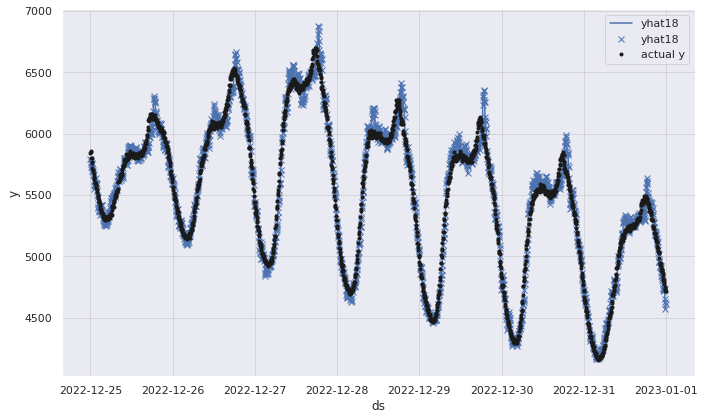

In [15]:
fig = m_base.plot(forecast.tail(12*24*7))


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


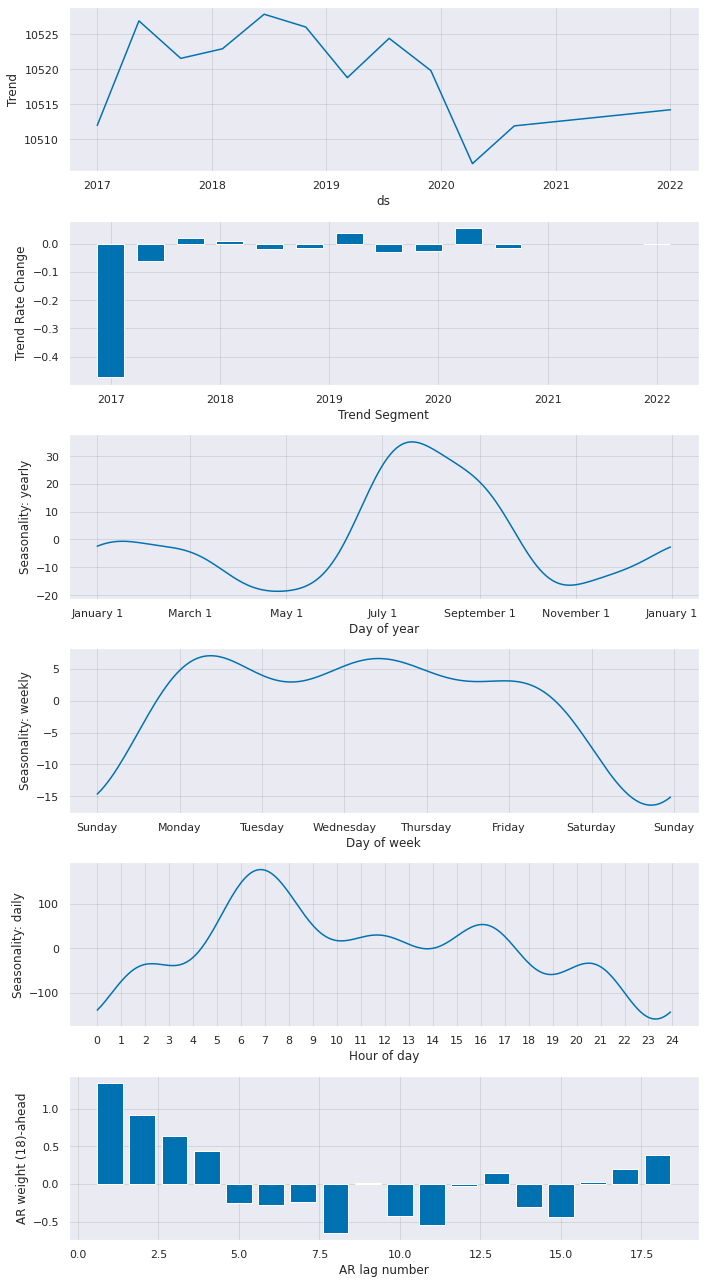

In [16]:
fig_param = m_base.plot_parameters()

In [ ]:
with open(f'{MODEL_DIR}/neuralprophet_base.pkl', "wb") as f:
    pickle.dump(m_base, f)
# forecast.to_csv(f'{FORECAST_DIR}/neuralprophet_base.csv')

# Model with Holiday


In [14]:
m_h= NeuralProphet(n_lags=18,
                      n_forecasts = 18,
                      yearly_seasonality=True,
                      weekly_seasonality=True, 
                      daily_seasonality=True,
                      num_hidden_layers = 1,
                      d_hidden = 100, 
                      epochs = 5)

m_h = m_h.add_country_holidays("US", lower_window=1, upper_window=1)
m_h = m_h.highlight_nth_step_ahead_of_each_forecast(18)


In [ ]:
set_random_seed(2023)
train_base, val_base = get_cols()
m_h_metric = m_h.fit(train_base, 
                    validation_df = val_base,
                    freq='5min')
m_h_metric

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 806it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.8/dist-packages/neuralprophet/forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

  df_forecast[name] = yhat

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


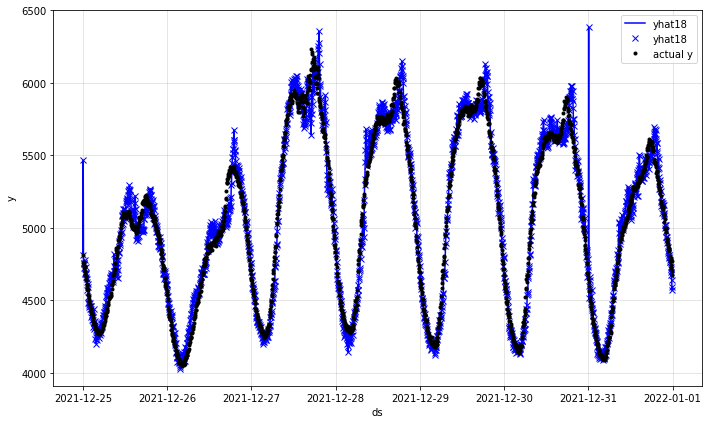

In [ ]:
forecast_h = m_h.predict(val_base)[35:]
fig = m_h.plot(forecast_h.tail(12*24*7))


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


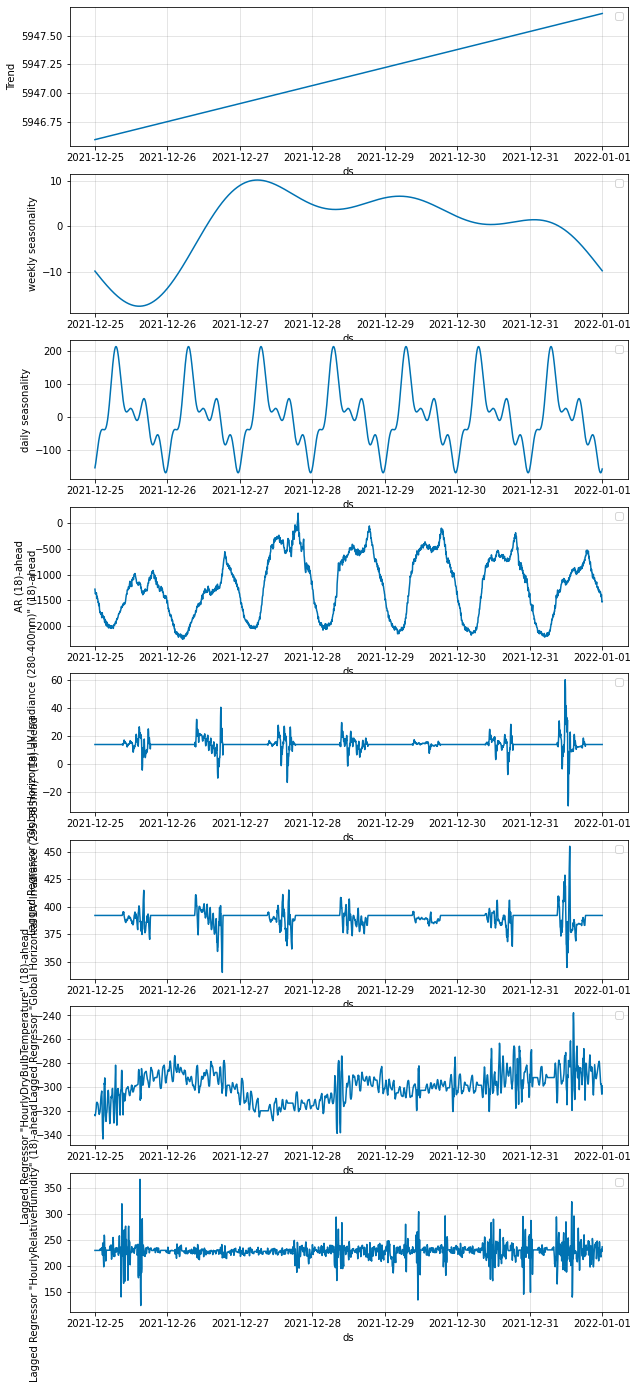

In [ ]:
fig_param = m_h.plot_parameters()

In [ ]:
# with open(f'{MODEL_DIR}/neuralprophet_h.pkl', "wb") as f:
#     pickle.dump(m_h, f)
forecast_h.to_csv(f'{FORECAST_DIR}/neuralprophet_h.csv')

# Model with Holiday and weather 


In [ ]:
m_h_w = NeuralProphet(n_lags=18,
                      n_forecasts = 18,
                      yearly_seasonality=False, #should set to True for full data set 
                      weekly_seasonality=True, 
                      daily_seasonality=True,
                      num_hidden_layers = 1,
                      epochs = 5)

m_h_w = m_h_w.add_country_holidays("US", lower_window=1, upper_window=1)
m_h_w = m_h_w.add_lagged_regressor(names=list(NYC)[2:]) 
m_h_w = m_h_w.highlight_nth_step_ahead_of_each_forecast(18)


INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)
INFO:NP.forecaster:n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)


In [ ]:
set_random_seed(2023)
m_h_w_metric = m_h_w.fit(df_train,
                          validation_df = df_validate,
                          freq='5min')
m_h_w_metric

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO:NP.config:Auto-set batch_size to 128


Finding best initial lr:   0%|          | 0/275 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,216.958969,247.432922,0.001612,0.0,0,1669.867920,2093.782471,0.142863,0.0
1,69.429993,98.924698,0.000257,0.0,1,110.770790,143.641769,0.000423,0.0
2,71.254097,97.486084,0.000250,0.0,2,79.621155,105.882645,0.000228,0.0
3,55.606991,84.041161,0.000186,0.0,3,67.834213,91.811668,0.000170,0.0
4,54.680775,82.668732,0.000180,0.0,4,63.303223,86.588257,0.000151,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 806it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.8/dist-packages/neuralprophet/forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

  df_forecast[name] = yhat

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


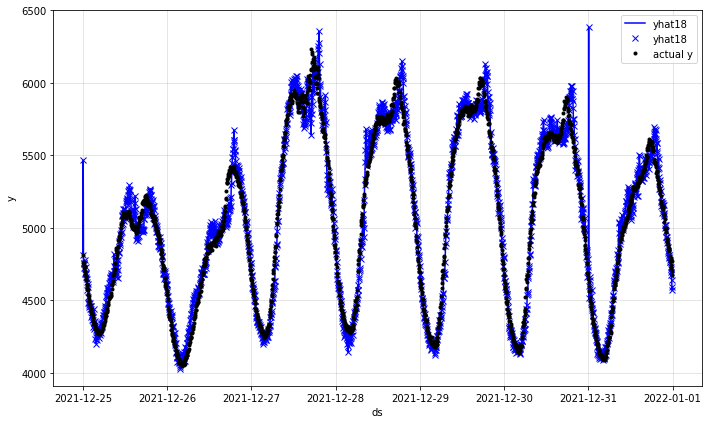

In [ ]:
forecast_h_w = m_h_w.predict(NYC)
fig = m_h_w.plot(forecast_h_w.loc[n-t:,])


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


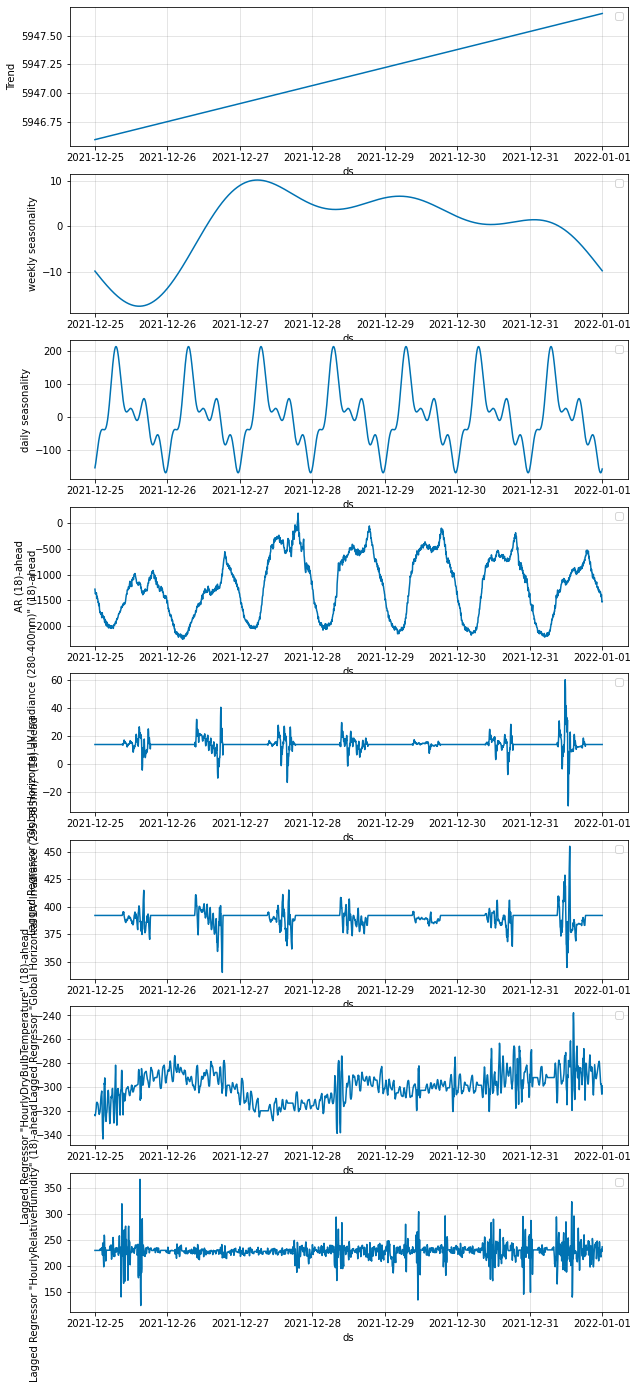

In [ ]:
param = m_h_w.plot_components(forecast_h_w.loc[n-t:,])

# Model with weather 


In [ ]:
m_w = NeuralProphet(n_lags=18,
                      n_forecasts = 18,
                      yearly_seasonality=False, #should set to True for full data set 
                      weekly_seasonality=True, 
                      daily_seasonality=True,
                      num_hidden_layers = 1,
                      epochs = 5)

m_w = m_w.add_lagged_regressor(names=list(NYC)[2:], n_lags = 'scalar') 
m_w = m_w.highlight_nth_step_ahead_of_each_forecast(18)


INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'scalar', number of lags for regressor is set to 1
INFO:NP.forecaster:n_lags = 'scalar', number of lags for regressor is set to 1


In [ ]:
set_random_seed(2023)
m_w_metric = m_w.fit(df_train,
              validation_df = df_validate,
              freq='5min')
m_w_metric

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO:NP.config:Auto-set batch_size to 128


Finding best initial lr:   0%|          | 0/275 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,201.781708,244.450989,0.001576,0.0,0,1675.156616,2103.141357,0.145355,0.0
1,86.218185,106.735565,0.000300,0.0,1,132.978668,174.304016,0.000622,0.0
2,71.452126,86.762436,0.000199,0.0,2,79.212341,104.569771,0.000221,0.0
3,47.983242,64.198273,0.000109,0.0,3,62.927322,85.487236,0.000147,0.0
4,48.141243,64.499481,0.000110,0.0,4,58.526928,80.547272,0.000131,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 806it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


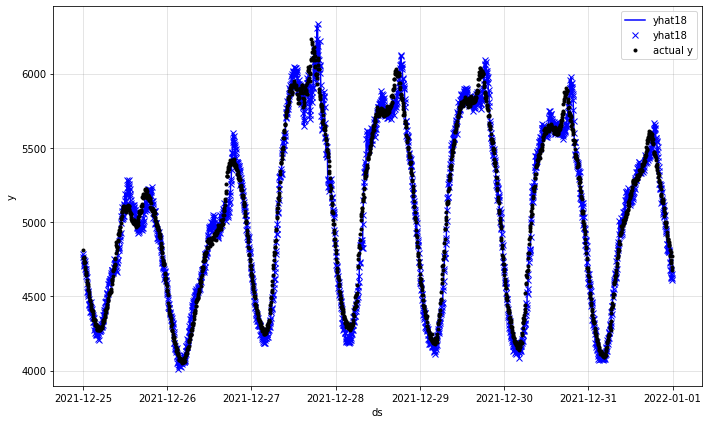

In [ ]:
forecast_w = m_w.predict(NYC)
fig = m_w.plot(forecast_w.loc[n-t:,])


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


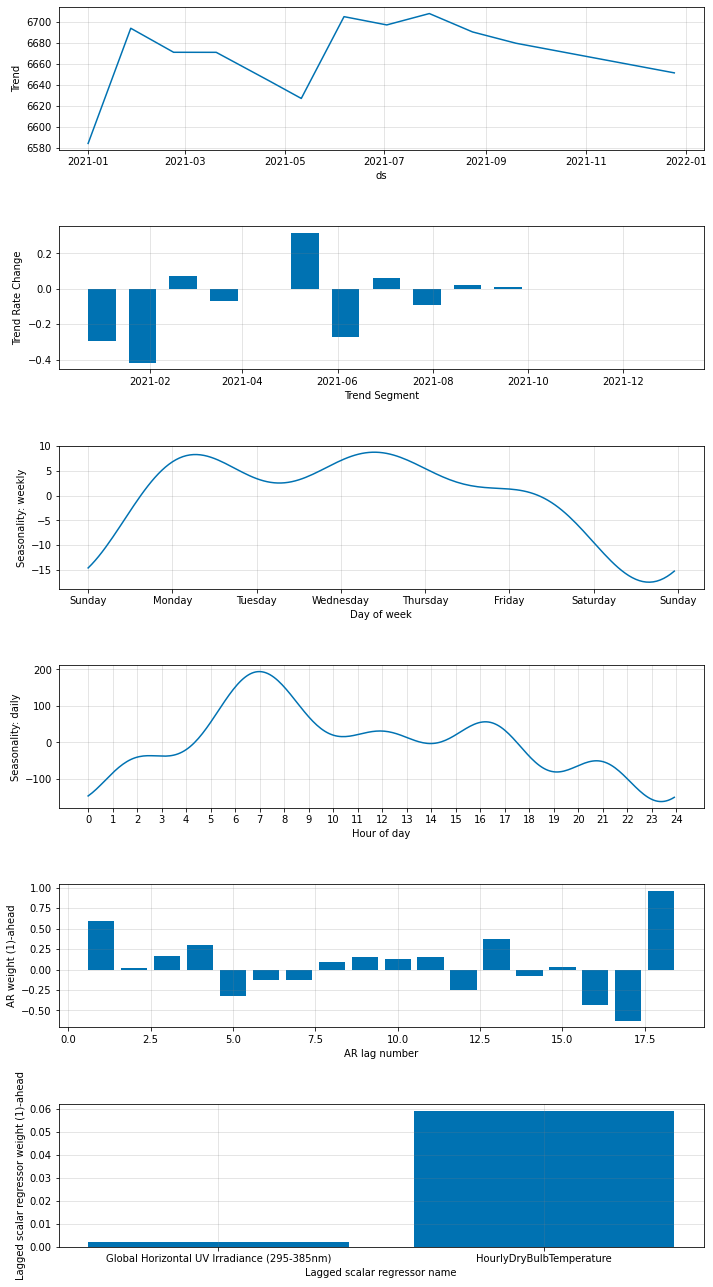

In [ ]:
param = m_w.plot_parameters(forecast_in_focus=1)